In [1]:
import tensorflow as tf
from keras.models import load_model
from keras.layers import *
from keras import Model, Input
from keras import optimizers
import keras.backend as K
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
import imageio
import cv2

def load(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

def crop_img(img):
    size = 256,256
    width, height = img.shape[:2]
    if img.ndim != 3: # remove bad images
        return None
    if width > height: # crop the image on width
        center = width // 2
        left = center - height//2
        right = center + height//2
        img = img[left:right,:,:]
    else: # crop the image on height
        center = height // 2
        up = center - width//2
        down = center + width//2
        img = img[:,up:down,:]
    # resize the image
    img = cv2.resize(img, dsize=size)
    return img
    
def load_jpg(filepath):
    with open(filepath, 'rb') as f:
        img = np.array(imageio.imread(f), dtype=np.float32) / 255
    return crop_img(img)
    
    

dataTriple = load('obj/triplets.pkl')
triplets = dataTriple['triplets'] / 255

/home/henrik/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
def get_images(conImg, styImg):
    conImg = conImg.reshape(1,256,256,3)
    styImg = styImg.reshape(1,256,256,3)
    genImg = conImg.copy() + 0.01* np.random.randn(*conImg.shape)
    genImg = np.clip(genImg, 0, 1)
    return conImg, styImg, genImg
    

In [3]:
def get_nets():
    custom_objects={'tf':tf}
    content_model = load_model('obj/content_model.h5', custom_objects=custom_objects)
    style_model = load_model('obj/style_model.h5', custom_objects=custom_objects)
    return content_model, style_model

def get_merged_model():
    
    conTensor = K.variable(np.zeros((1,256,256,3)), dtype=np.float32)
    styTensor = K.variable(np.zeros((1,256,256,3)), dtype=np.float32)
    genTensor = K.placeholder(dtype=np.float32, shape=(None,256, 256, 3))
    conW = K.variable(1, dtype=np.float32)
    styW = K.variable(1, dtype=np.float32)
    smoW = K.variable(1, dtype=np.float32)
    
    hor_diff = tf.reduce_sum((genTensor[:,:255,:,:] - genTensor[:,1:,:,:]) ** 2)
    vert_diff = tf.reduce_sum((genTensor[:,:,:255,:] - genTensor[:,:,1:,:]) ** 2)
    diag1_diff = tf.reduce_sum((genTensor[:,1:,1:,:] - genTensor[:,:255,:255,:]) ** 2) / 1.4
    diag2_diff = tf.reduce_sum((genTensor[:,1:,:255,:] - genTensor[:,:255,1:,:]) ** 2) / 1.4
    smoothLoss = smoW * (hor_diff + vert_diff + diag1_diff + diag2_diff)
    
    conIn = Input(tensor=conTensor)
    styIn = Input(tensor=styTensor)
    genIn = Input(tensor=K.clip(genTensor, 0, 1))
    conModel, styModel = get_nets()
    
    conLoss = conModel([conIn, genIn]) * conW
    styLoss = styModel([styIn, genIn]) * styW
    totLoss = (styLoss + conLoss + smoothLoss) / (conW + styW + smoW)
    
    grads = K.gradients(totLoss, genTensor)
    data = {
            'conTensor': conTensor, 'styTensor': styTensor, 'genTensor': genTensor,
            'styLoss': styLoss, 'conLoss': conLoss, 'totLoss': totLoss,
            'conW': conW, 'styW': styW, 'smoW' : smoW,
            'grads': grads
           }
    
    
    loss_fcn = K.function([genTensor], [totLoss])
    grad_fcn = K.function([genTensor], grads)
    def calc_opt(genImg):
        if genImg.shape != (1, 256, 256, 3):
            genImg = genImg.reshape((1, 256, 256, 3))
        loss = loss_fcn([genImg])[0]
        grad = grad_fcn([genImg])[0].flatten().astype('float64')
        return loss, grad
    
    data['calc_opt'] = calc_opt
    
    return data




In [4]:
model_data = get_merged_model()

/home/henrik/miniconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


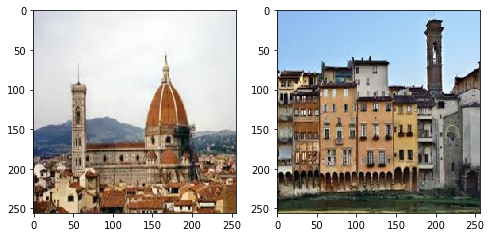

In [8]:
new_img = load_jpg('obj/Starry-Night.jpg')
conImg, styImg, genImg = get_images(triplets[43,0], triplets[44,0])
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(conImg.reshape(256,256,3))
plt.subplot(1,2,2)
plt.imshow(styImg.reshape(256,256,3))
plt.show()

[[20.883783]]
[[4.2276177]]


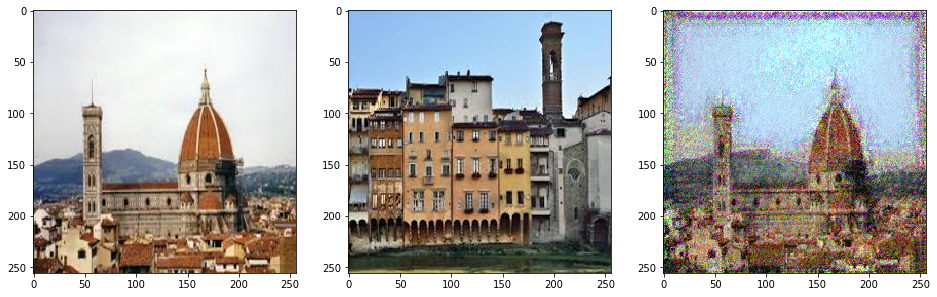

In [9]:
genImg = genImg.flatten().astype('float32')
asg1 = tf.assign(model_data['conTensor'], conImg)
asg2 = tf.assign(model_data['styTensor'], styImg)
asg3 = tf.assign(model_data['conW'], 1)
asg4 = tf.assign(model_data['styW'], 1e4)
asg5 = tf.assign(model_data['smoW'], 1e-2)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=5/6)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([asg1, asg2, asg3, asg4, asg5])
    calc_opt = model_data['calc_opt']
    print(calc_opt(genImg)[0])
    genImg, f_val, info = fmin_l_bfgs_b(calc_opt, genImg, maxiter=500, disp=True, epsilon=10)
    genImg = np.clip(genImg, 0, 1)
    print(calc_opt(genImg)[0])
    genImg = genImg.reshape(256,256,3)


plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(conImg.reshape(256,256,3))
plt.subplot(1,3,2)
plt.imshow(styImg.reshape(256,256,3))
plt.subplot(1,3,3)
plt.imshow(genImg)
plt.show()